# Our Project: Video Scene Classification

## Motivation
In the past few years, video-related technologies have developed rapidly, and many companies that have applied video technologies have achieved great success, such as TikTok, Tesla. Video scene classification has applications in many fields, such as short video recommendation algorithms, multimedia search based on video content, and autonomous driving environment perception systems. Specifically, when a self-driving car recognizes that the surrounding scene is a highway instead of an urban road by capturing a video, the car may change its driving mode. But classifying video scenes efficiently and accurately is still a huge challenge because of the complex and changeable scenes. Since the video has information in the time dimension that the picture does not have, the angle of processing the information becomes particularly important. We can also explore the impact of different types of neural networks on the accuracy of video scene classification. Therefore, we decided to do a video scene classification project.

## Project description
We would like to build a video scene classification system using deep learning techniques. We take video clips as the input of this system. After inferencing, the system will output the corresponding scene type of each clip. We will first build a new video dataset with scene labels using web scrapers. In order to control the computational cost of the model at a reasonable level, we will set limitations to the number of videos and types of labels so that the problem won’t be too complicated. Then, we will do a series of data exploration and preprocess the data for our system. After these procedures, we will begin to build our neural networks. The basic structure of this model is described in the next section. 

# Data Preparation

## Data Collection

### Overview
The preliminary data collection is done by Ou Longshen. Addtional data collection is done by Zhang Junzhe and Zhang Shuo. 

Following the research of [1], we would like to collect a dataset similar to the "Maryland in-the-wild" dataset, both in the label categories and the scale. We choose the above scenes as our classification labels:
- drive in downtown
- drive in countryside
- raining
- snowing
- forest fire
- volcanic eruption
- waterfall
- waves
- boiling water
- fountain

These labels are chosen because we assume that the motion of the scene contains descriptive information that help to recognize the scene in the video. For example, the static images of a waterfall and a sea wave may look alike and not easy to be distinguished. But if we add temperal information to this task, things get much easier for human because we can notice the different movement pattern of water.

To fully utilize the temporal information in our scene classification task, we made several restriction to the video we plan to collect:
- The whole video depicts the same scene 
- There should be dynamic motion of objects in the scene
- We try to avoid the movement of camera because this may disturb the recognition of scene motion

In addition, to ensure the diversity of our dataset, different videos clips should be took for different scenes, or a same scene but from different perspectives. 

In the preliminary collection, we collect 10 short videos for each class. The length of each video is 10 second. For the additional collection, we limit the number of classes to 5, and collect 10 more videos for thoses classes.

[1]: N. Shroff, P. Turaga, and R. Chellappa, “Moving vistas: Exploiting motion for describing scenes,” Proc. IEEE Comput. Soc. Conf. Comput. Vis. Pattern Recognit., pp. 1911–1918, 2010, doi: 10.1109/CVPR.2010.5539864.

### Method of collection
Due to our strict requirement for the video (described in previous section), we need to manually judge whether a clip of video fulfil our requirement. We search videos by keyword in a video streaming websites, select qualified clips from a bunch of video, and record them in a txt file that has the below format:

    Raining
        https://www.youtube.com/watch?v=OqOuBpg1jt8     0:00-0:10
        https://www.youtube.com/watch?v=s0ui0X-4bjc     0:05-0:15
        ...

    Snowing
        https://www.youtube.com/watch?v=XNdg06Ec-vI     0:22-0:32
        https://www.youtube.com/watch?v=xnKa0ttazfU     0:09-0:19   1:14-1:24    2:18-2:28
        ...
    ...

Then we use a parser function to convert it to json format. This convertion aims to simplify our donwloading and video cutting scripts.

In [ ]:
import json
def parse_txt():
    dataset_obj = {}

    with open('url_and_clips_full.txt', 'r') as f:
        lines = f.readlines()
    for line in lines:
        line = line.strip()
        print(len(line), line)

        if 0 < len(line) < 30:  # new class object
            class_name = line
            videos = {}
        elif len(line) >= 30:
            t = list(filter(None, line.split(' ')))
            url = t.pop(0)
            video_name = url.split('=')[1]
            clips = t
            videos[video_name] = {'url': url, 'clips': clips}
        else:  # finish object construction
            dataset_obj[class_name] = videos

    res = json.dumps(dataset_obj, indent=4, sort_keys=True)
    print(res)
    with open('url_and_clips_full.json', 'w') as f:
        f.write(res)

The resulting file looks like this:

    {
    "Boiling_water": {
        "-Aq6QSibHNI": {
            "clips": [
                "1:50-2:00"
            ],
            "url": "https://www.youtube.com/watch?v=-Aq6QSibHNI"
        },
        ...
    },
    "Drive_countryside": {
        "BQjavqQqi-0": {
            "clips": [
                "19:55-20:05",
                "33:20-33:30",
                "50:50-60:00",
                "58:40-58:50",
                "1:12:15-1:12:25"
            ],
            "url": "https://www.youtube.com/watch?v=BQjavqQqi-0"
        },
        ...
    ...

We use yt_dlp library as our downloading tools. Below is the script of downloading videos in the json files.

In [ ]:
import yt_dlp
import os
import shutil
import time
dataset_root = './dataset_100/raw'
for class_name in data:
    class_path = os.path.join(dataset_root, class_name)
    if not os.path.exists(class_path):
        os.mkdir(class_path)
    class_dic = data[class_name]
    files_in_cls_folder = os.listdir(os.path.join(dataset_root, class_name))
    for video_name in class_dic:
        video_dic = class_dic[video_name]
        print('Download {} ...'.format(video_name))

        # Skip if exists
        exists = False
        for filename in files_in_cls_folder:
            if video_name in filename:
                exists = True
                break
        if exists:
            continue
        
        # download
        with yt_dlp.YoutubeDL({}) as ydl:
            ydl.download([video_dic['url']])
        time.sleep(1)

        # rename and move to corresponding folder
        files = os.listdir('.')
        print(files)
        video_cnt = 0
        video_file_name = None
        for filename in files:
            if 'mkv' in filename or 'mp4' in filename or 'webm' in filename:
                video_cnt += 1
                video_file_name = filename
        assert video_cnt == 1

        print('Move {} ...'.format(video_name))
        shutil.move('./'+video_file_name, class_path)

After that, we use moviepy library to cut the original video to get the clips we want:

In [ ]:
def t2s(t):
    fs = t.strip().split(":")
    if len(fs) == 2:
        m,s = fs
        h = 0
    elif len(fs) == 3:
        h,m,s = fs
    else: 
        raise ValueError('Invalid time string: ' + t)
    return int(h) * 3600 + int(m) * 60 + int(s)

from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
import json
import os

# Create folders
dataset_root = './dataset_100'
class_folders = os.listdir(os.path.join(dataset_root, 'raw'))
for class_name in class_folders:
    class_path = os.path.join(dataset_root, 'clips', class_name)
    if not os.path.exists(class_path):
        os.mkdir(class_path)

# Read the json files
with open('url_and_clips_full.json', 'r') as f:
    text = f.read()
data = json.loads(text)
print(json.dumps(data,indent=4,sort_keys=True))

# Cut the videos
dataset_root = './dataset_100'
files_in_clips_folder = os.listdir(os.path.join(dataset_root, 'clips'))
for class_name in data:
    class_dic = data[class_name]
    files_in_cls_folder = os.listdir(os.path.join(dataset_root, 'raw', class_name))
    for video_name in class_dic:
        video_dic = class_dic[video_name]

        # Skip if exists
        exists = False
        for filename in files_in_clips_folder:
            if video_name in filename:
                exists = True
                break
        if exists:
            # print('exists')
            continue

        # find the corresponding video file
        video_file_name = None
        video_file_path = None
        for filename in files_in_cls_folder:
            if video_name in filename:
                video_file_name = filename
                break
        if video_file_name == None:
            raise Exception('Video file not exist: ', video_name)

        try:
            # cut
            clips = video_dic['clips']
            print(clips)
            for clip in clips:
                start_time_str = clip.split('-')[0]
                start_time = t2s(start_time_str)
                end_time = start_time + 10
                src = os.path.join(dataset_root, 'raw', class_name, video_file_name)
                dst = os.path.join(dataset_root, 'clips', class_name + '_' + video_name + start_time_str.replace(':','')) + '.webm'
                print(src, dst)
                ffmpeg_extract_subclip(src, start_time, end_time, targetname=dst)
        except:
            print('Error happens')
            print(src)

Finally, we split the dataset into three non-overlapping subsets with ratio of 6:2:2, to serve as training set, validation set, testing set respectively.

However, in the preliminary experiments, our network shows very poor generization ability on this dataset. This should be caused by the limited number of videos per class (currently 10) and relatively too many number of classes (also 10). To solve this problem, we limit the number of classes to 5, and collect 10 more videos for the 5 classes, and use the train/validation/test split ratio 14:3:3. We use the second dataset for our following experiments.

## Data Exploration
In this section, we will do some preliminary analysis to the data we collected. This section is done by Ou Longshen.

### Observation
We select some frames from our dataset and display them with the corresponding labels.

<Figure size 432x288 with 0 Axes>

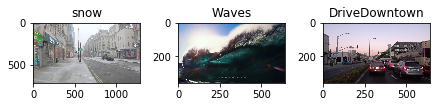

In [ ]:
dataset_root = 'data/'
from PIL import Image
import matplotlib.pyplot as plt
img_paths = ['train/snow/2/2.png', 'train/Waves/3/3.png', 'train/DriveDowntown/4/4.png']

fig = plt.figure()
fig, axs = plt.subplots(1, 3, constrained_layout=True)

for i in range(len(img_paths)):
    axs[i].imshow(Image.open(dataset_root+img_paths[i]))
    axs[i].set_title(img_paths[i].split('/')[1])

plt.show()

### Label 
We have five labels in all. They are:
- Snowing
- Forest
- Volcanic eruption
- Waves
- Drive in downtown

The data is evenly distributed among the labels, and each label has 20 video clips. This is the result of our data collection strategy, and prevent the data imbalance problem in advance. The relatively small number of categories lower the difficulty of the problem, so that we can easily control the scale of our models.

### Mean and Stand Deviation of different channels
We compute the mean and std different channels in our data. These statistics is useful in furture data normalization.

In [ ]:
import os
import torchvision as tv
import torchvision.transforms.functional as TF
dataset_root = 'data/'
a = os.walk(dataset_root)
imgs = []
for root, directories, filenames in a:
    if len(directories) > 0:
        continue
    for filename in filenames:
        path = os.path.join(root, filename)
        img = tv.io.read_image(path)
        img = TF.resize(img, size=[270, 480])
        imgs.append(img/255)
    

In [ ]:
import torch
all_data_tensor = torch.stack(imgs)
print(all_data_tensor.dtype)
print('shape:', all_data_tensor.shape)
mean = all_data_tensor.mean(dim=[0,2,3])
std = all_data_tensor.std(dim=[0,2,3])
print('Mean:', mean)
print('Std:', std)


torch.float32
shape: torch.Size([494, 3, 270, 480])
Mean: tensor([0.3840, 0.3828, 0.3885])
Std: tensor([0.2694, 0.2637, 0.2758])


### Visulization
We use PCA and t-SNE to reduce the data dimension to two so that we can give a straightforward visualization of our data. We select the first frame in one video to represent the video it belongs to.

In [ ]:
import os
import torchvision as tv
import torchvision.transforms.functional as TF
dataset_root = 'data/'
a = os.walk(dataset_root)
imgs = []
labels = []
for root, directories, filenames in a:
    if len(directories) > 0:
        continue
    for filename in filenames:
        path = os.path.join(root, filename)
        # print(path)
        if '0.png' in path:
            img = tv.io.read_image(path)
            img = TF.resize(img, size=[270, 480])
            imgs.append(img/255)
            labels.append(path.split('\\')[-3])
imgs = torch.stack(imgs)


Computing PCA projection


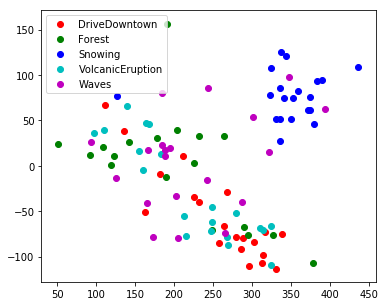

In [ ]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble, discriminant_analysis, random_projection)

color = {
    'DriveDowntown':0,
    'forest':1,
    'snow':2,
    'VolcanicEruption':3,
    'Waves':4
}
X = imgs.view(imgs.shape[0],-1).numpy()
t = []
for i in labels:
    t.append(color[i])
y = np.array(t)

n_samples, n_features = X.shape
n_neighbors = 30

## Computing PCA
print("Computing PCA projection")
t0 = time()
X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X)

X_2d = X_pca

target_names = ['DriveDowntown', 'Forest','Snowing','VolcanicEruption','Waves']
target_ids = range(5)

from matplotlib import pyplot as plt
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm'
for i, c, label in zip(target_ids, colors, target_names):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], c=c, label=label)
plt.legend()
plt.show()

Computing t-SNE embedding


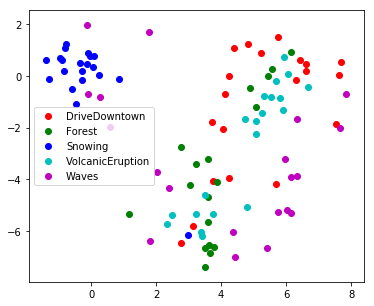

In [ ]:
print("Computing t-SNE embedding")
X = imgs.view(imgs.shape[0],-1).numpy()
t = []
for i in labels:
    t.append(color[i])
y = np.array(t)

target_ids = range(5)

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(X)

target_names = ['DriveDowntown', 'Forest','Snowing','VolcanicEruption','Waves']

from matplotlib import pyplot as plt
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm'
for i, c, label in zip(target_ids, colors, target_names):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], c=c, label=label)
plt.legend()
plt.show()

We can draw a preliminary conclusion that the "snowing" class is more easy to be seperated from other 4 classes, while the other classes is not so straightforward to be distinguished.

## Data Preprocessing

This section contains the data preprocessing method in our project, done by ZHANG SHUO.

In [ ]:
import cv2, os

file = 'path to each collected video'
video = cv2.VideoCapture(file)
# align FPS to 30 for each video
video.set(cv2.CAP_PROP_FPS, int(30))
ret = True
i = 0
n = 1
j = 0

while ret:
    os.makedirs(f'path to save the clips for each video/clip{n}', exist_ok=True)
    ret, frame = video.read()
    if i % 30 == 0:
        # save one frame every second
        if ret:
            cv2.imwrite(os.path.join(f'path to save the clips for each video/clip{n}', f'{j}.png'), frame)
            j += 1
    # start saving the next clip if 5 frames are accumulated
    if j == 5:
        n += 1
        j = 0
    i += 1

We collect several videos for each class and extract clips for each video every 5 seconds and save the frame every second, which means there would be 5 frames in each clip repository. The result for a video of class 'forest' is shown in the following picture.
2021-10-31 21-32-51屏幕截图.png

In each clip repository, we saved frames of five seconds.
2021-10-31 21-34-35屏幕截图.png
2021-10-31 21-34-47屏幕截图.png

Data cleaning is done manually. Some clips is iterrupted due to the sampling so we need to select the proper clips for our training. The first clip in the following is valid but the second is not suitable.
2021-10-31 21-40-46屏幕截图.png 
2021-10-31 21-41-12屏幕截图.png

# Deep learning solutions

## Environment setup

The following shows the basic configurations for the python environment and preparation for the dataloader.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision as tv
import torch.nn as nn
import os
from PIL import Image as Img
from Utils import EarlyStopping
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import numpy as np

## MyDataset class construction

MyDataset could read the sequences in the correct order. We use five frames as standard value and if the number of frames is less than five, we supplement zeros. The data transformation includes resizing the image to the fixed size, transforming the data into tensor format which at the same time sets the data values between 0 and 1, and normalizing the data to the designated mean and std values. If needed, data augmentation, image flipping, could also be used in our code.

In [ ]:
cls = ['DriveDowntown', 'forest', 'snoe', 'VolcanicEruption', 'Waves']


class MyDataset(Dataset):
    def __init__(self, train_data_path, train=True):
        self.folder = train_data_path
        self.filenames = []
        self.train = train
        # loop over the dataset and save the paths of frame sequences and their labels
        for root, dirs, files in os.walk(train_data_path):
            y = -1
            for c_name in dirs:
                for i in range(len(cls)):
                    if cls[i] == c_name:
                        y = i
                        break
                c_path = os.path.join(root, c_name)
                for r, ds, fs in os.walk(c_path):
                    for d in ds:
                        lst = []
                        d_path = os.path.join(c_path, d)
                        imgs = os.listdir(d_path)
                        # make sure the order of frames is the same as the video
                        imgs = sorted(imgs, key=lambda x: int(x.split('.')[0]))
                        for img in imgs:
                            lst.append(os.path.join(d_path, img))
                        self.filenames.append([lst[:], y])
                    break
            break
        self.trans = tv.transforms.Compose([
            tv.transforms.ToTensor(),
            tv.transforms.RandomHorizontalFlip(0.5),
            tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]) if train else tv.transforms.Compose([
            tv.transforms.ToTensor(),
            #tv.transforms.RandomHorizontalFlip(0.5),
            tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
        
    def __getitem__(self, idx):
        filename, label = self.filenames[idx]
        imgs = []
        for fi in filename[:5]:
            img = Img.open(fi)
            if img.mode != 'RGB':
                img = img.convert('RGB')
            # resize the image to the fixed size
            lr_img = img.resize((45, 27))
            h, w = lr_img.size
            lr_img = self.trans(lr_img)
            imgs.append(lr_img[np.newaxis, :, :, :])
        # if the number of frames is less than the maximum, supplement zeros
        if len(filename) < 5:
            n = 5-len(filename)
            temp = Img.new('RGB', (h, w), (0,0,0))
            temp = tv.transforms.ToTensor()(temp)[np.newaxis, :, :, :]
            imgs.append(temp.repeat(n, 1, 1, 1))
        # concat 5 images
        return torch.cat(imgs, 0), label

    def __len__(self):
        return len(self.filenames)

## MLP

### Basic MLP

MLP section is done by ZHANG JUNZHE. Here we first implement a simple MLP model based on our dataset. Significantly, since MLP can only handle vectors, and the fully connected layer needs to learn more parameters, we use MyDataset to resize the frames to a smaller resolution and flatten them into vectors. For basic MLP, we use three fully connected layers with a hidden state of 200. At the same time, we adopted a dropout layer to prevent overfitting. Finally, we concatenate the 5 output vectors and take the mean value as the final output result.

In [ ]:
class MLP(nn.Module):
    def __init__(self, num_cls):
        super().__init__()
        self.layer1 = nn.Linear(  3645   , 200  , bias=True  )
        self.layer2 = nn.Linear(  200 , 200  , bias=True  )
        self.layer3 = nn.Linear(  200 , num_cls   , bias=True  )
        self.relu = nn.ReLU()
    def forward(self, input):
        b, t, c, h, w = input.shape
        lst = []
        for i in range(int(t)):
            x = input[:, i, :, :, :]
            x = x.view(1,3645)

            x = self.layer1(x)
            x = F.dropout(self.relu(x), p=0.5, training=self.training)
            x = self.layer2(x)
            x = F.dropout(self.relu(x), p=0.5, training=self.training)
            x = self.layer3(x)
            lst.append(x[:, np.newaxis, :])
        x = torch.mean(torch.cat(lst, 1), 1)
        
        return x

### Improved MLP

For improved MLP, we propose to introduce skip connection into the model which we refer to the skip connection in ResNet. Skip connection can reduce the information loss of the fully connected layer in the parameter transfer process, and the model only needs to learn the difference between the input and output of the model. In our improved MLP model, we use the sum of the outputs of the first and second layers as the input of the third layer. The result shows our idea is effective.

In [ ]:
class MLP_imp(nn.Module):
    def __init__(self, num_cls):
        super().__init__()

        self.layer1 = nn.Linear(  3645   , 200  , bias=True  )
        self.layer2 = nn.Linear(  200 , 200  , bias=True  )
        self.layer3 = nn.Linear(  200 , num_cls   , bias=True  )
        self.relu = nn.ReLU()

    def forward(self, input):
        b, t, c, h, w = input.shape
        lst = []
        for i in range(int(t)):
            x = input[:, i, :, :, :]
            x = x.view(1,3645)
            x_skip = F.dropout(F.relu(self.layer1(x)), p=0.5, training=self.training)
            x_2 = F.dropout(F.relu(self.layer2(x_skip)), p=0.5, training=self.training)
            x_3 = F.relu(self.layer3(x_skip+x_2))
            lst.append(x_3[:, np.newaxis, :])

        x = torch.mean(torch.cat(lst, 1), 1)
        return x 

### Set parameters

In [ ]:
CLASS_NUM = 5

EPOCH = 100
BATCH_SIZE = 1
LR = 0.00001
MOMENTUM = 0.9
WEIGHT_DECAY = 0.
PATIENCE = 6

### Train

We use CrossEntropyLoss() and the EarlyStop mechanism to prevent the model from overfitting. At the same time, the results of the accuracy and loss changes are written into the tensorboard.

In [ ]:



def train(model_name, ctn=False, choice='basic'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    writer = SummaryWriter('log/' + model_name + '/')
    # should modify data path if you want to run it.
    dataset_train = MyDataset('data/train')
    train_loader = DataLoader(
        dataset=dataset_train,
        batch_size=BATCH_SIZE,
        shuffle=True,
    )
    # should modify data path if you want to run it.
    dataset_valid = MyDataset('data/valid', train=False)
    valid_loader = DataLoader(
        dataset=dataset_valid,
        batch_size=BATCH_SIZE,
        shuffle=False,
    )

    # Model, optimizer, loss function, earlystopping
    if choice == 'basic':
      net = MLP(CLASS_NUM).to(device)
    else:
      net = MLP_imp(CLASS_NUM).to(device)

    if ctn == True:
        net.load_state_dict(torch.load('models/' + model_name + '.pth'))
    print(net)
    for i in net.modules():
        print('-', i)
    optimizer = torch.optim.Adam(net.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    loss_func = nn.CrossEntropyLoss()
    early_stopping = EarlyStopping(PATIENCE, verbose=True)

    # Training and validating
    for epoch in range(EPOCH):
        running_loss = 0.0
        step_cnt = 0
        corr_cnt = 0
        for step, (b_x, b_y) in enumerate(train_loader):
            b_x = b_x.to(device)
            b_y = b_y.to(device)
            out = net(b_x)
            loss = loss_func(out, b_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            step_cnt += 1

            # Compute Accuracy
            pred_out = torch.max(torch.softmax(out, dim=1), 1)[1]
            pred_y = pred_out.data.cpu().numpy().squeeze()
            target_y = b_y.data.cpu().numpy()
            accuracy = sum(pred_y == target_y) / BATCH_SIZE
            corr_cnt += sum(pred_y == target_y)

            # print result
            print('Epoch: {} | Step: {} / {} | Accuracy: {:.4f} | Loss: {:.4f}'.format(
                epoch, step, len(train_loader), accuracy, loss.item()
            ))
        avg_train_loss = running_loss / step_cnt
        train_acc = corr_cnt / len(dataset_train)

        # Validating
        running_loss = 0.0
        step_cnt = 0
        corr_cnt = 0
        with torch.no_grad():
            for step, (batch_x, batch_y) in enumerate(valid_loader):
                # Compute Loss
                out = net(batch_x.to(device))
                loss = loss_func(out, batch_y.to(device))
                running_loss += loss.item()
                step_cnt += 1

                # Compute Accuracy
                pred = torch.max(torch.softmax(out, dim=1), dim=1)[1]
                pred = pred.data.cpu().numpy().squeeze()
                batch_y = batch_y.data.cpu().numpy()
                corr_cnt += sum(pred == batch_y)
        valid_acc = corr_cnt / len(dataset_valid)
        avg_valid_loss = running_loss / step_cnt
        print('Validation Loss: {} | Accuracy: {}'.format(avg_valid_loss, valid_acc))

        # Visualization
        writer.add_scalars('Training Loss Graph', {'train_loss': avg_train_loss,
                                                   'validation_loss': avg_valid_loss}, epoch)
        writer.add_scalars('Training Acc Graph', {'train_acc': train_acc,
                                                  'validation_acc': valid_acc}, epoch)

        early_stopping(avg_valid_loss, net)
        if early_stopping.early_stop == True:
            print("Early Stopping!")
            break

    # save models in designated location
    import shutil
    shutil.move('checkpoint.pth', 'models/' + model_name + '.pth')

##### Start training of basic MLP

In [ ]:
train('mlp', choice='basic')

##### Start training of improved MLP

In [ ]:
train('mlp_imp', choice='improved')

### Test

In [ ]:
def test(test_model_path, choice='basic'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if choice == 'basic':
      model = MLP(CLASS_NUM).to(device)
    else:
      model = MLP_imp(CLASS_NUM).to(device)
    model.load_state_dict(torch.load(test_model_path))

    dataset_test = MyDataset('data/test', train=False)
    test_loader = DataLoader(
        dataset=dataset_test,
        batch_size=BATCH_SIZE,
        shuffle=False,
    )

    loss_func = nn.CrossEntropyLoss()

    corr_cnt = 0
    step_cnt = 0
    running_loss = 0.0
    with torch.no_grad():
        for step, (b_x, b_y) in enumerate(test_loader):
            # Compute loss
            out = model(b_x.to(device))
            loss = loss_func(out, b_y.to(device))
            running_loss += loss.item()
            step_cnt += 1

            # Compute Accuracy
            pred = torch.max(torch.softmax(out, dim=1), 1)[1]
            pred = pred.data.cpu().numpy().squeeze()
            b_y = b_y.data.cpu().numpy()
            corr_cnt += sum(pred == b_y)

    test_acc = corr_cnt / len(dataset_test)
    avg_test_loss = running_loss / step_cnt
    print('Testing Dataset Loss: {} | Accuracy: {}'.format(avg_test_loss, test_acc))

    return avg_test_loss, test_acc

##### test basic MLP

In [ ]:
test('models/mlp.pth')

Testing Dataset Loss: 0.9297838559995095 | Accuracy: 0.6666666666666666


(0.9297838559995095, 0.6666666666666666)

##### test improved MLP

In [ ]:
test('models/mlp_imp.pth')

Testing Dataset Loss: 0.7033206610319515 | Accuracy: 0.6666666666666666


(0.7033206610319515, 0.6666666666666666)

### Results

### Interpretation and Analysis

#### Basic MLP

##### The process of training and validation visualization:  
The figure below shows the change in accuracy and loss of basic MLP. We can see that the accuracy on the training set can reach 88%, and the loss can be reduced to 0.4. The accuracy on the validation set is 73%, and the loss is about 0.68. The test dataset’s accuracy is 53% and loss is 0.99.  
As you can see, because the data distribution of the training and validation set are not the same, there is a gap between their performance. At the same time, we found that due to the simplicity of the MLP structure, the performance of the model is not that good. Especially in the performance on the verification set and the test set, the loss on the validation set is 0.68 which is a little high, the accuracy on the test set is 53% which is bad, and the loss is as high as 0.99 which is also high.

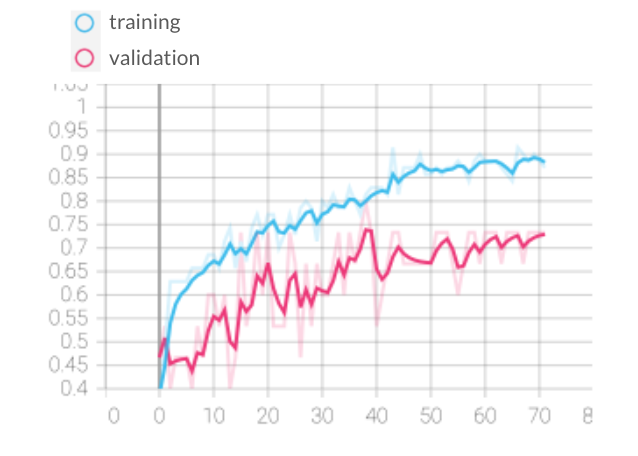
avatar

#### Improved MLP

##### The process of training and validation visualization:  
The figure below shows the change in accuracy and loss of improved MLP. The performance has indeed improved. The improvement on the training set is more apparent, and its accuracy has reached 93%, and the loss was reduced to 0.34. The accuracy on the validation set is 75% which is a little higher than that of the basic MLP, and the loss was reduced to 0.65. This may be due to the difference in the data distribution between the training set and the validation set. The test dataset’s accuracy is 73% and loss is 0.74. From the perspective of the test set, we have indeed improved the performance of the model through the skip connection method.

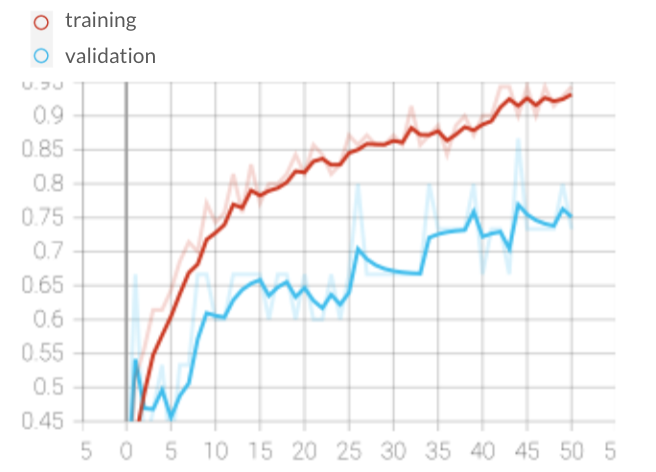
avatar

### Conclusion

Since there are too many parameters in the fully connected layer, MLP can get a not bad result after we resize and flatten the frames. But because it can neither learn spatial information like CNN nor temporal information like RNN, its performance is not very satisfactory. At the same time, it is proved through experiments that MLP can indeed reduce the information loss in the transmission process and improve the performance of the model by referring to the skip connection in ResNet.

## CNN
CNN section is done by ZHANG SHUO. Here we first implement a simple CNN model based on our dataset and then propose to introduce temporal information into the model, in a convolutional way. The result shows our idea is effective. 

### Implementation and improvement

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_cls):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(20, 30, kernel_size=3, padding=1)
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.linear_final = nn.Linear(30, num_cls)
    def forward(self, input):
        b, t, c, h, w = input.shape
        lst = []
        for i in range(int(t)):
            x = input[:, i, :, :, :]
            x = self.pool(self.relu(self.conv1(x)))
            x = self.pool(self.relu(self.conv2(x)))
            x = self.pool(self.relu(self.conv3(x)))
            lst.append(x[:, np.newaxis, :, :, :])
        x = torch.sum(torch.cat(lst, 1), 1)
        x = self.avg_pool(x)
        x = self.linear_final(x.reshape(-1, 30))
        return x

The basic simple CNN consists of three layers with 10, 20, 30 as output channels. A Relu function and Pooling layer follow each conv to improve the generalization and training efficiency of the network. We use the same conv kernels across the time steps in a sequence and then sum over the feature maps for each second to get the representation of the sequence. The AdaptiveAvgPool2d is applied to calculate the average features in x, y dimensions. Finally a fc layer is used to get the score for each class.

In [ ]:
class CNN_up(nn.Module):
    def __init__(self, num_cls):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=3, padding=1)
        self.conv12 = nn.Conv2d(10, 20, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(3, 10, kernel_size=3, padding=1)
        self.conv22 = nn.Conv2d(10, 20, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(3, 10, kernel_size=3, padding=1)
        self.conv32 = nn.Conv2d(10, 20, kernel_size=3, padding=1)
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.linear_final = nn.Linear(60, num_cls)
    def forward(self, input):
        b, t, c, h, w = input.shape
        lst = []
        for i in range(0, int(t)-2):
            x1 = input[:, i, :, :, :]
            x1 = self.pool(self.relu(self.conv1(x1)))
            x1 = self.pool(self.relu(self.conv12(x1)))
            x2 = input[:, i+1, :, :, :]
            x2 = self.pool(self.relu(self.conv2(x2)))
            x2 = self.pool(self.relu(self.conv22(x2)))
            x3 = input[:, i+2, :, :, :]
            x3 = self.pool(self.relu(self.conv3(x3)))
            x3 = self.pool(self.relu(self.conv32(x3)))
            x = x1+x2+x3
            lst.append(x[:, :, :, :])
        x = torch.cat(lst, 1)
        x = self.avg_pool(x)
        x = self.linear_final(x.reshape(-1, 60))
        return x

Next we try to improve the CNN model. We introduce temporal information into the model. Let's set the temporal size as 3, which means we apply different conv kernels inside each group including consecutive three frames and slip across the time dimension, from frame1, frame2, frame3 to frame(n-2), frame(n-1), frame(n). This can introduce the temporal relationship into the model, not only the spatial information. For each frame, we apply conv kernels to get the image representation.

In [ ]:
CLASS_NUM = 5
EPOCH = 50
BATCH_SIZE = 2
LR = 0.001
MOMENTUM = 0.9
WEIGHT_DECAY = 0.
PATIENCE = 6

In [ ]:
def train(model_name, ctn=False, choice='basic'):
    device = torch.device("cuda")
    writer = SummaryWriter('log/' + model_name + '/')

    dataset_train = MyDataset('data/train')
    train_loader = DataLoader(
        dataset=dataset_train,
        batch_size=BATCH_SIZE,
        shuffle=True,
    )
    
    dataset_valid = MyDataset('data/valid', train=False)
    valid_loader = DataLoader(
        dataset=dataset_valid,
        batch_size=BATCH_SIZE,
        shuffle=False,
    )

    # Model, optimizer, loss function, earlystopping
    if choice == 'basic':
      net = CNN(CLASS_NUM).to(device)
    else:
      net = CNN_up(CLASS_NUM).to(device)
    if ctn == True:
        net.load_state_dict(torch.load('models/' + model_name + '.pth'))
    print(net)
    for i in net.modules():
        print('-', i)
    optimizer = torch.optim.Adam(net.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    loss_func = nn.CrossEntropyLoss()
    early_stopping = EarlyStopping(PATIENCE, verbose=True)

    # Training and validating
    for epoch in range(EPOCH):
        running_loss = 0.0
        step_cnt = 0
        corr_cnt = 0
        for step, (b_x, b_y) in enumerate(train_loader):
            b_x = b_x.to(device)
            b_y = b_y.to(device)
            out = net(b_x)
            loss = loss_func(out, b_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            step_cnt += 1

            # training acc
            pred_out = torch.max(torch.softmax(out, dim=1), 1)[1]
            pred_y = pred_out.data.cpu().numpy().squeeze()
            target_y = b_y.data.cpu().numpy()
            accuracy = sum(pred_y == target_y) / BATCH_SIZE
            corr_cnt += sum(pred_y == target_y)

            print('Epoch: {} | Step: {} / {} | Accuracy: {:.4f} | Loss: {:.4f}'.format(
                epoch, step, len(train_loader), accuracy, loss.item()
            ))

        avg_train_loss = running_loss / step_cnt
        train_acc = corr_cnt / len(dataset_train)

        # Validating
        running_loss = 0.0
        step_cnt = 0
        corr_cnt = 0  
        with torch.no_grad():
            for step, (batch_x, batch_y) in enumerate(valid_loader):
                out = net(batch_x.to(device))
                loss = loss_func(out, batch_y.to(device))
                running_loss += loss.item()
                step_cnt += 1

                pred = torch.max(torch.softmax(out, dim=1), dim=1)[1]
                pred = pred.data.cpu().numpy().squeeze()
                batch_y = batch_y.data.cpu().numpy()
                corr_cnt += sum(pred == batch_y)
        valid_acc = corr_cnt / len(dataset_valid)
        avg_valid_loss = running_loss / step_cnt
        print('Validation Loss: {} | Accuracy: {}'.format(avg_valid_loss, valid_acc))

        # Visualization
        writer.add_scalars('Training Loss Graph', {'train_loss': avg_train_loss,
                                                   'validation_loss': avg_valid_loss}, epoch)
        writer.add_scalars('Training Acc Graph', {'train_acc': train_acc,
                                                  'validation_acc': valid_acc}, epoch)

        early_stopping(avg_valid_loss, net)
        if early_stopping.early_stop == True:
            print("Early Stopping!")
            break

    # save models in designated location
    import shutil
    shutil.move('checkpoint.pth', 'models/' + model_name + '.pth')

Training and validation code.

In [ ]:
torch.cuda.is_available()

Check if gpu is available

In [ ]:
train('10', choice='basic')

Start training and validation for basic CNN.

In [ ]:
train('9', choice='temporal')

Start training and validation for temporal CNN.

In [ ]:
def test(test_model_path, choice='basic'):
    device = torch.device("cuda")
    if choice == 'basic':
      model = CNN(CLASS_NUM).to(device)
    else:
      model = CNN_up(CLASS_NUM).to(device)
    model.load_state_dict(torch.load(test_model_path))

    dataset_test = MyDataset('data/test', train=False)
    test_loader = DataLoader(
        dataset=dataset_test,
        batch_size=BATCH_SIZE,
        shuffle=False,
    )

    loss_func = nn.CrossEntropyLoss()

    corr_cnt = 0
    step_cnt = 0
    running_loss = 0.0
    d={0:[0, 0], 1:[0, 0], 2:[0, 0], 3:[0, 0], 4:[0, 0]}
    with torch.no_grad():
        for step, (b_x, b_y) in enumerate(test_loader):
            out = model(b_x.to(device))
            loss = loss_func(out, b_y.to(device))
            running_loss += loss.item()
            step_cnt += 1

            pred = torch.max(torch.softmax(out, dim=1), 1)[1]
            pred = pred.data.cpu().numpy().squeeze()
            b_y = b_y.data.cpu().numpy()
            t = pred == b_y
            for i in range(len(t)):
                d[b_y[i]][1] += 1
                d[b_y[i]][0] += int(t[i])
            corr_cnt += sum(pred == b_y)
        for i in d:
            d[i] = d[i][0]/d[i][1]

    test_acc = corr_cnt / len(dataset_test)
    avg_test_loss = running_loss / step_cnt
    print('Tesing Dataset Loss: {} | Accuracy: {}'.format(avg_test_loss, test_acc))
    print("Result for each class: ", d)
    return avg_test_loss, test_acc

In [ ]:
test('models/10.pth')

Test for basic CNN.

In [ ]:
test('models/9.pth', 'temporal')

Test for improved temporal CNN.

### Result of CNN

#### Basic CNN:

##### training and validation visualization:




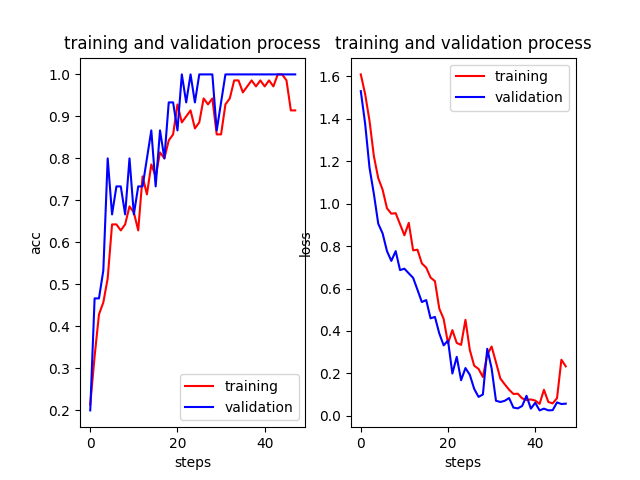

We can see both the accuracies of training and validation are increasing, and the losses decline stablely. The accuracy of validation is close to 1 and the loss is close to 0.1 at the end.


##### Test result:
- Tesing Dataset Loss: 0.5078554999417975 | Accuracy: 0.8
- Result for each class:  {0: 1.0, 1: 1.0, 2: 1.0, 3: 0.67, 4: 0.33}

#### Temporal convolutional network

##### training and validation visualisation:



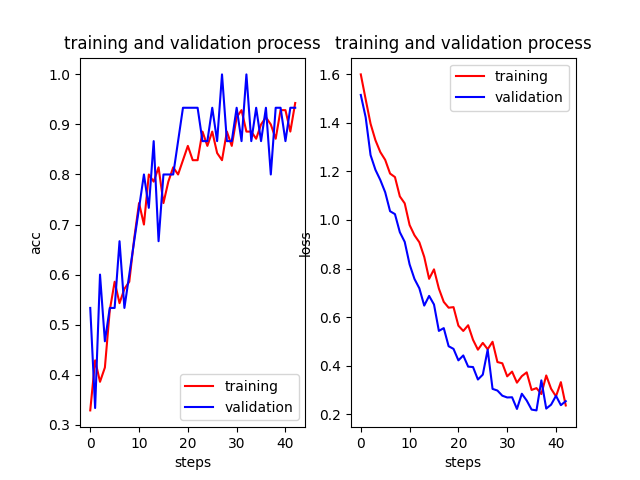

We can see the training is also very stable, but after a few steps the validation acc achieves 0.6, which is much faster than basic CNN, showing that introducing temporal information could enhance the training. The losses in the end are a little higher than basic CNN.

##### Test result:
- Tesing Dataset Loss: 0.5139940390360493 | Accuracy: 0.87
- Result for each class:  {0: 1.0, 1: 1.0, 2: 1.0, 3: 0.67, 4: 0.67}

The general test acc improves and the main improvement is for class 4. The accuracies of class 1, 2, 3 are the same. In troducing temporal information is beneficial for the representation of the wave video. 

#### Comparison between basic and temporal CNN


The wave clip where temporal CNN succeeds but basic CNN fails is shown in the following pictures:

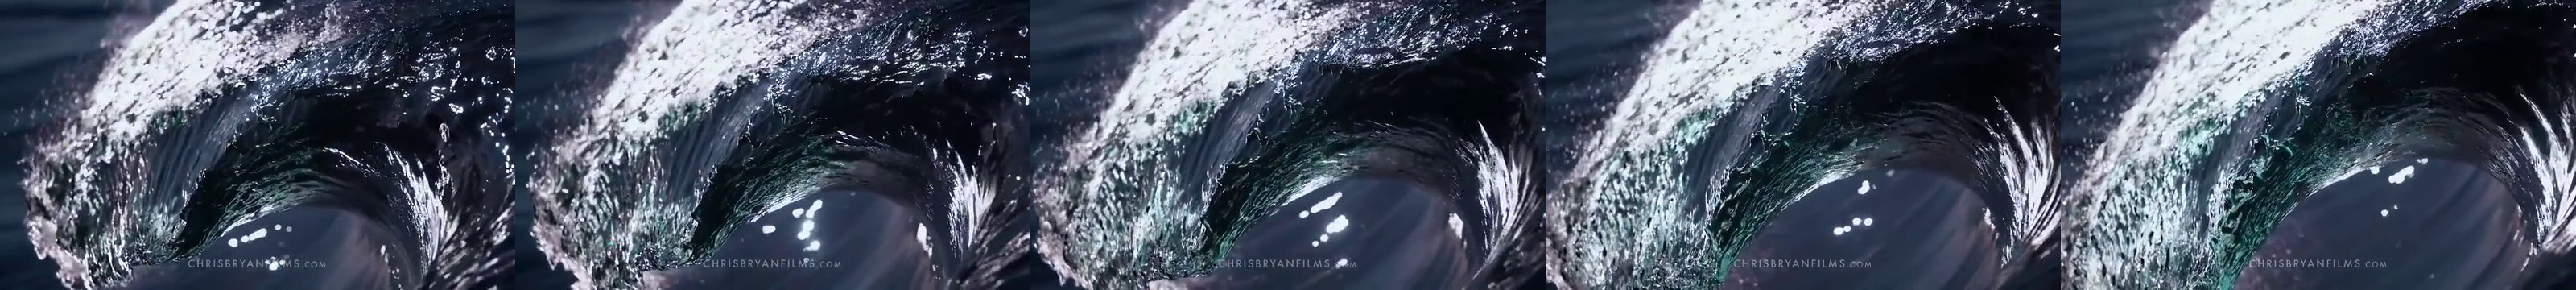

From the consecutive frames for the wave clip, the changing of status is obvious and this is also the main reason basic CNN fails to predict on this clip. The clip proves our idea that temporal information is useful for predicting on clips whose status change obviously. 

The clip shown following is in class 3, where both models fail:

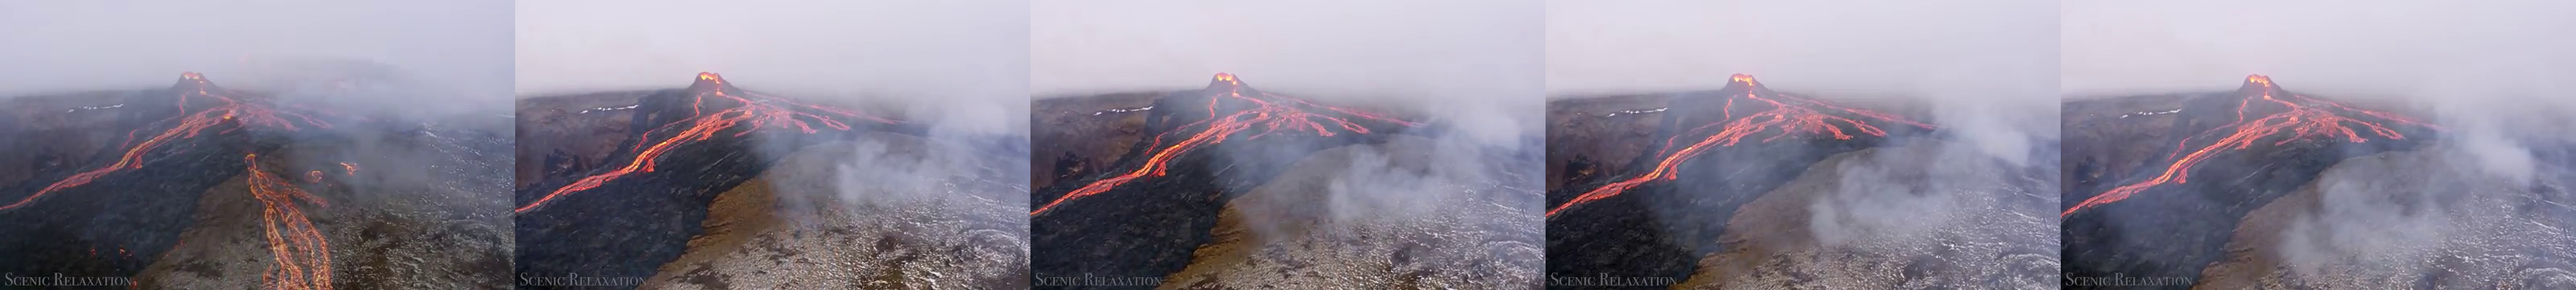


The frames also change a lot during five seconds and both the two models fail to predict on the clip. More temporal relationship and stronger spatial representation are needed for the CNN to capture the changes between frames.

## RNN

### MyDataset class for RNN

MyDataset could read the sequences in the correct order. We use five frames as standard value and if the number of frames is less than five, we supplement zeros. The data transformation includes resizing the image to the fixed size, transforming the data into tensor format which at the same time sets the data values between 0 and 1, and normalizing the data to the designated mean and std values. If needed, data augmentation, image flipping, could also be used in our code. 
   
Significantly, since RNN can only handle vectors, we still resize the frames to a smaller resolution. But for our improved RNN, we can resize it to a larger resolution. The specific reasons will be explained in the next section. So if you only want to test the performance of the improved RNN, you only need to load the second MyDataset.

In [ ]:
cls = ['DriveDowntown', 'forest', 'snow', 'VolcanicEruption', 'Waves']

class MyDataset(Dataset):
    def __init__(self, data_path, train=True):
        self.folder = data_path
        self.filenames = []
        self.train = train
        # loop over the dataset and save the paths of frame sequences and their labels
        for root, dirs, files in os.walk(data_path):
            y = -1
            for c_name in dirs:
                for i in range(len(cls)):
                    if cls[i] == c_name:
                        y = i
                        break
                c_path = os.path.join(root, c_name)
                for r, ds, fs in os.walk(c_path):
                    for d in ds:
                        lst = []
                        d_path = os.path.join(c_path, d)
                        imgs = os.listdir(d_path)
                        # make sure the order of frames is the same as the video
                        imgs = sorted(imgs, key=lambda x: int(x.split('.')[0]))
                        for img in imgs:
                            lst.append(os.path.join(d_path, img))
                        self.filenames.append([lst[:], y])
                    break
            break
        self.trans = tv.transforms.Compose([
            tv.transforms.ToTensor(),
            tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]) 

    def __getitem__(self, idx):
        filename, label = self.filenames[idx]
        imgs = []
        for fi in filename[:5]:
            img = Img.open(fi)
            if img.mode != 'RGB':
                img = img.convert('RGB')
            # resize the image to the fixed size
            lr_img = img.resize((48, 27))
            h, w = lr_img.size
            lr_img = self.trans(lr_img)
            imgs.append(lr_img[np.newaxis, :, :, :])
        # if the number of frames is less than the maximum, supplement zeros
        if len(filename) < 5:
            n = 5-len(filename)
            temp = Img.new('RGB', (h, w), (0,0,0))
            temp = tv.transforms.ToTensor()(temp)[np.newaxis, :, :, :]
            imgs.append(temp.repeat(n, 1, 1, 1))
        # concat 5 images
        return torch.cat(imgs, 0), label

    def __len__(self):
        return len(self.filenames)

For the improved RNN, you only need to load the following MyDataset which resizes the frames to (128,72).

In [ ]:
cls = ['DriveDowntown', 'forest', 'snow', 'VolcanicEruption', 'Waves']
class MyDataset(Dataset):
    def __init__(self, data_path, train=True):
        self.folder = data_path
        self.filenames = []
        self.train = train
        # loop over the dataset and save the paths of frame sequences and their labels
        for root, dirs, files in os.walk(data_path):
            y = -1
            for c_name in dirs:
                for i in range(len(cls)):
                    if cls[i] == c_name:
                        y = i
                        break
                c_path = os.path.join(root, c_name)
                for r, ds, fs in os.walk(c_path):
                    for d in ds:
                        lst = []
                        d_path = os.path.join(c_path, d)
                        imgs = os.listdir(d_path)
                        # make sure the order of frames is the same as the video
                        imgs = sorted(imgs, key=lambda x: int(x.split('.')[0]))
                        for img in imgs:
                            lst.append(os.path.join(d_path, img))
                        self.filenames.append([lst[:], y])
                    break
            break
        self.trans = tv.transforms.Compose([
            tv.transforms.ToTensor(),
            tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]) 

    def __getitem__(self, idx):
        filename, label = self.filenames[idx]
        imgs = []
        t = random.random()
        for fi in filename[:5]:
            img = Img.open(fi)
            if img.mode != 'RGB':
                img = img.convert('RGB')

            # resize the image to the fixed size
            lr_img = img.resize((128, 72))
            h, w = lr_img.size
            lr_img = self.trans(lr_img)
            imgs.append(lr_img[np.newaxis, :, :, :])

        # if the number of frames is less than the maximum, supplement zeros
        if len(filename) < 5:
            n = 5-len(filename)
            temp = Img.new('RGB', (h, w), (0,0,0))
            temp = tv.transforms.ToTensor()(temp)[np.newaxis, :, :, :]
            imgs.append(temp.repeat(n, 1, 1, 1))
        # concat 5 images
        return torch.cat(imgs, 0), label

    def __len__(self):
        return len(self.filenames)

### Basic RNN

RNN section is done by ZHANG JUNZHE. Here we first implement a simple RNN model based on LSTM with a hidden state of 200. Significantly, since RNN can only handle vectors, we still resize frames into smaller resolution frames. Then flatten them and input them into LSTM.  
  
In terms of models, we initially tried a 3-layer LSTM, but we found that the results were over-fitting. Therefore, we decided to reduce the complexity of the model and use a 1-layer LSTM instead. At the same time, we only select the last hidden state output result, because it contains all the previous hidden state information. We still use the dropout layer to prevent overfitting.

In [ ]:
class RNN(nn.Module):
    def __init__(self, num_cls):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=3888,
            hidden_size=200,        
            num_layers=1,       
            batch_first=True,
        )
        self.fc1 = nn.Linear(200, 100)
        self.fc2 = nn.Linear(100, num_cls)
    def forward(self, input):
        b, t, c, h, w = input.shape
        x = input.view(b, t, 3888)
        x, (h_n, h_c) = self.lstm(x, None)
        # FC layers
        # choose RNN_out at the last time step
        x = self.fc1(x[:, -1, :])
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)

        return x

### Improved RNN

Then we tried to improve RNN. Since RNN only learns the information on the time series and lacks the feature extraction of spatial information, we introduce one layer of CNN as the feature extractor to learn the spatial information of the frames.  
  
Significantly, since CNN can handle feature maps, we increase the frame resolution to (128, 72). After the frames pass CNN and linear layer, the feature vector is used as the input of LSTM. The result shows our idea is effective.

In [ ]:
class RNN_imp(nn.Module):
    def __init__(self, num_cls):
        super().__init__()
        self.conv = nn.Conv2d(3, 10, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.lstm = nn.LSTM(
            input_size=1000,
            hidden_size=200,        
            num_layers=1,       
            batch_first=True,
        )
        self.fc_conv = nn.Linear(23040, 1000)
        self.fc1 = nn.Linear(200, 100)
        self.fc2 = nn.Linear(100, num_cls)

    def forward(self, input):
        b, t, c, h, w = input.shape
        lst = []
        for i in range(int(t)):
            x = input[:, i, :, :, :]
            x = self.pool(F.relu(self.conv(x)))
            x = self.fc_conv(x.view(-1, 23040))
            lst.append(x[:, np.newaxis, :])
        x = torch.cat(lst, 1)
        x, (h_n, h_c) = self.lstm(x, None)
        # FC layers
        # choose RNN_out at the last time step
        x = self.fc1(x[:, -1, :])
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)

        return x

### Set parameters

In [ ]:
CLASS_NUM = 5
EPOCH = 50
BATCH_SIZE = 2
LR = 0.0001
MOMENTUM = 0.9
WEIGHT_DECAY = 0.
PATIENCE = 6

### Train

We use CrossEntropyLoss() and the EarlyStop mechanism to prevent the model from overfitting. At the same time, the results of the accuracy and loss changes are written into the tensorboard.

In [ ]:
def train(model_name, ctn=False, choice='basic'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    writer = SummaryWriter('log/' + model_name + '/')
    # should modify data path if you want to run it.
    dataset_train = MyDataset('data/train')
    train_loader = DataLoader(
        dataset=dataset_train,
        batch_size=BATCH_SIZE,
        shuffle=True,
    )
    # should modify data path if you want to run it.
    dataset_valid = MyDataset('data/valid', train=False)
    valid_loader = DataLoader(
        dataset=dataset_valid,
        batch_size=BATCH_SIZE,
        shuffle=False,
    )

    # Model, optimizer, loss function, earlystopping
    if choice == 'basic':
      net = RNN(CLASS_NUM).to(device)
    else:
      net = RNN_imp(CLASS_NUM).to(device)
    if ctn == True:
        net.load_state_dict(torch.load('models/' + model_name + '.pth'))
    print(net)
    for i in net.modules():
        print('-', i)
    optimizer = torch.optim.Adam(net.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    loss_func = nn.CrossEntropyLoss()
    early_stopping = EarlyStopping(PATIENCE, verbose=True)

    # Training and validating
    for epoch in range(EPOCH):
        running_loss = 0.0
        step_cnt = 0
        corr_cnt = 0
        for step, (b_x, b_y) in enumerate(train_loader):
            b_x = b_x.to(device)
            b_y = b_y.to(device)
            out = net(b_x)
            loss = loss_func(out, b_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            step_cnt += 1

            # Compute Accuracy
            pred_out = torch.max(torch.softmax(out, dim=1), 1)[1]
            pred_y = pred_out.data.cpu().numpy().squeeze()
            target_y = b_y.data.cpu().numpy()
            accuracy = sum(pred_y == target_y) / BATCH_SIZE
            corr_cnt += sum(pred_y == target_y)

            # print result
            print('Epoch: {} | Step: {} / {} | Accuracy: {:.4f} | Loss: {:.4f}'.format(
                epoch, step, len(train_loader), accuracy, loss.item()
            ))

        avg_train_loss = running_loss / step_cnt
        train_acc = corr_cnt / len(dataset_train)

        # Validating
        running_loss = 0.0
        step_cnt = 0
        corr_cnt = 0  
        with torch.no_grad():
            for step, (batch_x, batch_y) in enumerate(valid_loader):
                # Compute Loss
                out = net(batch_x.to(device))
                loss = loss_func(out, batch_y.to(device))
                running_loss += loss.item()
                step_cnt += 1

                # Compute Accuracy
                pred = torch.max(torch.softmax(out, dim=1), dim=1)[1]
                pred = pred.data.cpu().numpy().squeeze()
                batch_y = batch_y.data.cpu().numpy()
                corr_cnt += sum(pred == batch_y)
        valid_acc = corr_cnt / len(dataset_valid)
        avg_valid_loss = running_loss / step_cnt
        print('Validation Loss: {} | Accuracy: {}'.format(avg_valid_loss, valid_acc))

        # Visualization
        writer.add_scalars('Training Loss Graph', {'train_loss': avg_train_loss,
                                                   'validation_loss': avg_valid_loss}, epoch)
        writer.add_scalars('Training Acc Graph', {'train_acc': train_acc,
                                                  'validation_acc': valid_acc}, epoch)

        early_stopping(avg_valid_loss, net)
        if early_stopping.early_stop == True:
            print("Early Stopping!")
            break

    # save models in designated location
    import shutil
    shutil.move('checkpoint.pth', 'models/' + model_name + '.pth')

#### Start training of basic RNN

In [ ]:
train('rnn', choice='basic')

#### Start training of improved RNN

In [ ]:
train('rnn_imp', choice='improved')

### Test

In [ ]:
def test(test_model_path, choice='basic'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if choice == 'basic':
      model = RNN(CLASS_NUM).to(device)
    else:
      model = RNN_imp(CLASS_NUM).to(device)
    model.load_state_dict(torch.load(test_model_path))

    dataset_test = MyDataset('data/test', train=False)
    test_loader = DataLoader(
        dataset=dataset_test,
        batch_size=BATCH_SIZE,
        shuffle=False,
    )

    loss_func = nn.CrossEntropyLoss()

    corr_cnt = 0
    step_cnt = 0
    running_loss = 0.0
    with torch.no_grad():
        for step, (b_x, b_y) in enumerate(test_loader):
            # Compute loss
            out = model(b_x.to(device))
            loss = loss_func(out, b_y.to(device))
            running_loss += loss.item()
            step_cnt += 1

            # Compute Accuracy
            pred = torch.max(torch.softmax(out, dim=1), 1)[1]
            pred = pred.data.cpu().numpy().squeeze()
            b_y = b_y.data.cpu().numpy()
            corr_cnt += sum(pred == b_y)

    test_acc = corr_cnt / len(dataset_test)
    avg_test_loss = running_loss / step_cnt
    print('Tesing Dataset Loss: {} | Accuracy: {}'.format(avg_test_loss, test_acc))

    return avg_test_loss, test_acc

#### test basic RNN

In [ ]:
test('models/rnn.pth', choice='basic')

Tesing Dataset Loss: 0.8649567835964262 | Accuracy: 0.6666666666666666


(0.8649567835964262, 0.6666666666666666)

#### test improved RNN

In [ ]:
test('models/rnn_imp.pth', choice='improved')

Tesing Dataset Loss: 0.49315351189579815 | Accuracy: 0.8666666666666667


(0.49315351189579815, 0.8666666666666667)

### Results of Basic RNN

#### The process of training and validation visualization:  
The figure below shows the change in accuracy and loss of basic RNN. We can see that the accuracy on the training set can reach 99%, and the loss can be reduced to 0.12. The accuracy on the validation set is 73%, and the loss is about 0.73. The test dataset’s accuracy is 66% and loss is 0.87.  
  
As you can see, because the data distribution of the training and validation set are not the same, there is still a gap between their performance. At the same time, compared with basic MLP, we found that the performance of basic RNN on the training set has been significantly improved, but the performance of basic RNN on the validation set and test set has not been significantly improved. This is mainly because RNN and MLP are both processing vectors, and the model themselves have not learned the image features of frames, that is, spatial information.

avatar
avatar

### Results of Improved RNN

#### The process of training and validation visualization:  
The figure below shows the change in accuracy and loss of improved RNN. By introducing a CNN extractor to extract spatial information, we found that the performance has been significantly improved. On the training set, the accuracy of the model reached 100%, and the loss was reduced to 0.02. On the validation set, the accuracy of the model reached 93%, and the loss was reduced to 0.18. The test dataset’s accuracy is 93% and loss is 0.47.  
  
Although we only used a layer of CNN as the spatial information extractor, when we combined it with LSTM, the performance was significantly improved. The model can learn not only the spatial information of each frame, but also the temporal information through LSTM.

avatar
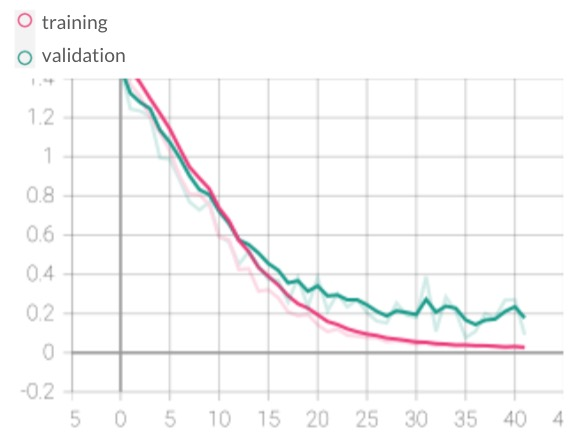

### Conclusion

Through comparison, we can conclude that although RNN has learned temporal information, it is limited by the lack of spatial information bottleneck. So the performance of basic RNN will not be significantly improved. But for video, once we use the spatial information and temporal information at the same time, the performance of the model will be significantly improved.

## Attention Neural Network 
In this section, we design an attention neural network architecture for the video scene classification task. This section is done by OU LONGSHEN.

### General Structure

Currently the Transformer is widely used in computer vision and video processing. We would like to try the Transformer's performance on our task. We are dealing with a classification task instead of sequence generation, so it's not feasible to use an autoregressive structure in our model. As a result, we use a stack of Transformer blocks—equivalant to only the encoder part of the original Transformer—as the main structure of our model. There are another two points of modification:
- The original word embedding layer is simply substitute by a position-wise linear layer which converts the dimension of input sequence to d_model for future computation.
- Finally, the output of the Transformer blocks (a sequence of vectors with dimension of $d_{model}$) is flattened and feed into a linear classifier, to get the final output. 

In [ ]:
def make_cls(src_dim, seq_len, cls_num, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = TransformerClassifier(
        encoder=Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        src_embed=nn.Linear(src_dim, d_model),
        classifier=LinearClassifier(d_model * seq_len, cls_num)
    )

    # This was important from their code.
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model


class TransformerClassifier(nn.Module):
    def __init__(self, encoder, src_embed, classifier):
        super(TransformerClassifier, self).__init__()
        self.encoder = encoder
        self.src_embed = src_embed
        self.classifier = classifier

    def forward(self, src, src_mask=None):
        "Take in and process masked src and target sequences."
        x = self.src_embed(src)
        x = self.encoder(x, src_mask)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

### Transformer implementation
Our implementation of Transformer largely follows "The Annotated Transformer[[1]]", including multi-head self-attention machenism, layer normalization, and so on.

[1]: https://nlp.seas.harvard.edu/2018/04/03/attention.html

In [ ]:
import math
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable


def make_cls(src_dim, seq_len, cls_num, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = TransformerClassifier(
        encoder=Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        src_embed=nn.Linear(src_dim, d_model),
        classifier=LinearClassifier(d_model * seq_len, cls_num)
    )

    # This was important from their code.
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model


def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn


def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


class TransformerClassifier(nn.Module):
    def __init__(self, encoder, src_embed, classifier):
        super(TransformerClassifier, self).__init__()
        self.encoder = encoder
        self.src_embed = src_embed
        self.classifier = classifier

    def forward(self, src, src_mask=None):
        "Take in and process masked src and target sequences."
        x = self.src_embed(src)
        x = self.encoder(x, src_mask)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x


class Generator(nn.Module):
    "Define standard linear + softmax generation step."

    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)


class LinearClassifier(nn.Module):
    "Define standard linear + softmax generation step."

    def __init__(self, d_model, vocab):
        super(LinearClassifier, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        x = self.proj(x)
        x = F.log_softmax(x, dim=-1)
        return x


class PositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        # div_term = 1 / (10000 ** (torch.arange(0., d_model, 2) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)],
                        requires_grad=False)
        return self.dropout(x)


class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."

    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))


class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
            for l, x in zip(self.linears, (query, key, value))]

        # 2) Apply attention on all the projected vectors in batch.
        x, self.attn = attention(query, key, value, mask=mask,
                                dropout=self.dropout)

        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous() \
            .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)


class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"

    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)


class Encoder(nn.Module):
    "Core encoder is a stack of N layers"

    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)


class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."

    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2


class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """

    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))


### Baseline model

#### Input
Our Transformer baseline model directly use the image pixels as input. However, it's not feasible to let the sequence length be equal to the number of frames we picked from the raw videos. A small sequence length will lead to a huge dimension of input tokens (the total number of pixels in a video frame) and then we have to set a big d_model for it to get rid of information loss, and finally lead to a huge number of parameters in the model. Instead, we choose to use the information contained in one line of pixels in a video frame, to serve as one input token, and the sequence length is frame number (5) times picture height (200 in current experiment) in this way. 

Our data loader provide data in the shape of [batch_size, frames, channels, height, width]. Before input the data into the transformer, we need to convert it to the shape of [batch_size, frames * height, channels * width]:

In [ ]:
class ANN_Basic(nn.Module):
    def __init__(self, transformer):
        super(ANN_Basic, self).__init__()
        self.transformer = transformer

    def forward(self, x):
        # input shape: [batch, frame, channel, height, width]
        x = x.permute(0, 1, 3, 2, 4)
        x = x.reshape(x.shape[0], 5 * h, 3, w)
        x = x.view(x.shape[0], 5 * h, 3 * w)

        x = self.transformer(x)
        return x

#### Hyper-parameters

|Hyper-param|Value|
| :---: | :---: |
|Input dimension|3*320|
|Sequence length|5*200|
|Number of Transformer blocks| 2 |
|$d_{model}$|128|
|$d_{ff}$|256|
|Batch size|8|
|Learning rate|1e-5|


This model consists of 1,028,229 trainable parameters. Since the basic CNN with only 7.5k parameters have reasonable performance on this small dataset, the scale of this model is definitely enough for solving this problem and even over-parameterized.

#### Experiments

During training, the network fits training data very quickly and has a good validation accuracy, about 87%. Here's the learning curve of the baseline model, computed on both training set and validation set: 

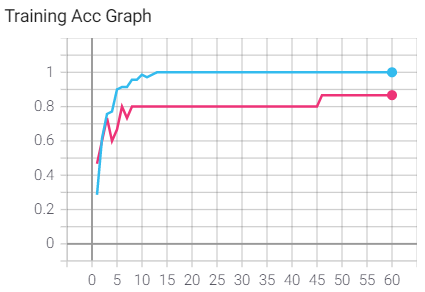|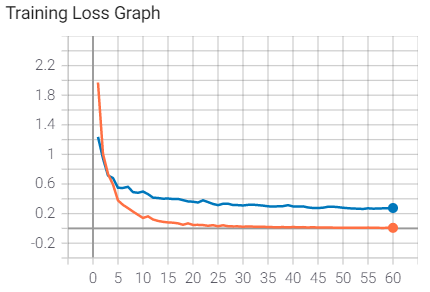

### Improve the ANN baseline

#### Structure

Similar to the basic RNN, the ANN baseline doesn't well utilized the spacial structure contained in the image. A simple translation operation on the raw video frames will lead to a completely different input sequence. A straightforward improvement direction is to add some layers to handel the translation invariance. In the beginning , we simply add two 2-d convolutional layers at the front of the baseline network, and get slightly better results.

The promising initial results motivate us to explor further in this direction. Finally, a series of convolutional layers with kernal size 3, combined with max pooling layers, is applied to the network. This enable the network to capture different scales of visual features. The output feature maps of convolutional layers are concatenate to form a new vector sequence and then we input it into the transformer network in a similar way. Due to the reduced sequence length, we increase the number of Transformer blocks to maintain the number of parameters to be similar to the basic model.

#### Hyper-parameters

|Hyper-param|Value|
| :---: | :---: |
|Input dimension|960|
|Sequence length|250|
|Number of Transformer blocks| 4 |
|$d_{model}$|128|
|$d_{ff}$|256|
|Batch size|8|
|Learning rate|5e-5|

This model consists of 815,655 trainable parameters.


In [ ]:
# Model structure
class ANN2(nn.Module):
    def __init__(self):
        super(ANN2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1)

        self.transformer = make_cls(src_dim=960, seq_len=250, cls_num=CLASS_NUM, N=N, d_model=D_MODEL, d_ff=D_FF, h=2)

    def forward(self, x):
        "Take in and process masked src and target sequences."
        x = x.permute(1, 0, 2, 3, 4)
        t = []
        for y in x:
            y = F.relu(self.conv1(y))
            y = F.relu(self.conv2(y))
            y = F.max_pool2d(y, kernel_size=2)
            y = F.relu(self.conv3(y))
            y = F.relu(self.conv4(y))
            y = F.max_pool2d(y, kernel_size=2)
            y = y.permute(0, 2, 3, 1)
            y = y.reshape(y.shape[0], y.shape[1], -1)
            t.append(y)
        x = torch.cat(t, dim=1)
        x = F.dropout(x, p=0.5)
        x = self.transformer(x)
        return x

#### Experiments

Here's the average loss and accuracy of the improved ANN during training, computed on both training set and validation set:

|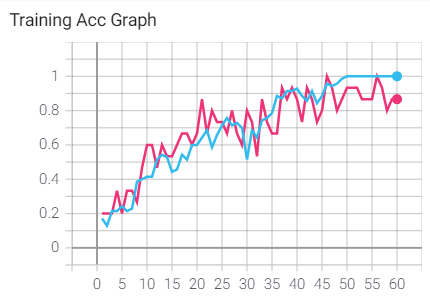 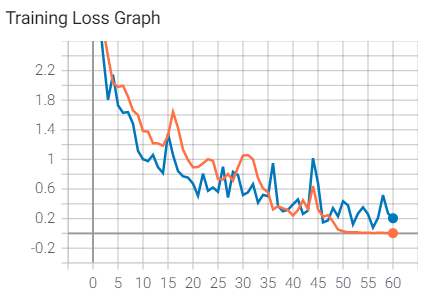

Here's the comparison of the baseline model and the improved model, on validation loss and accuracy:

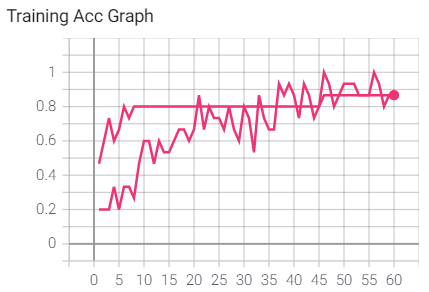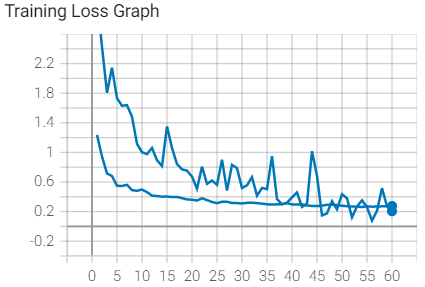

The additional convolutional layers make the learning speed slower, but finally the improved ANN converge with a lower validation loss (from 0.26 to 0.007) and higher validation accuracy (from 86.7% to 100%).

### Performance on test set
The basic ANN's test loss is 0.6512, test accuracy is 66.67%.  
The improved ANN's test loss is 1.4882, test accuracy is 73.33%

Although the improved ANN does better on accurately classifying videos, it has higher test loss than the basic model, which means that it is much more "uncertain" about the decision it makes. We argue that it is because the data in the test set seems to have different distribution from that of training set and validation set. This problem will be alleviated if we have collect more data for our dataset construction.